<a href="https://colab.research.google.com/github/rodeketan/CoviSense_Research_Navigator/blob/main/code_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import glob
import json
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

import matplotlib.pyplot as plt
plt.style.use('ggplot')


import warnings
warnings.filterwarnings("ignore")


In [ ]:
df_data = pd.read_csv("/content/data.csv", error_bad_lines=False)

In [ ]:
len(df_data)

8666

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz (500.6 MB)
  Preparing metadata (setup.py) ... done


In [ ]:
df = df_data.sample(6000, random_state=42)
del df_data

In [ ]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3779 entries, 3936 to 1884
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        3779 non-null   int64 
 1   paper_id          3779 non-null   object
 2   doi               3779 non-null   object
 3   abstract          3779 non-null   object
 4   body_text         3779 non-null   object
 5   authors           3779 non-null   object
 6   title             3779 non-null   object
 7   journal           3779 non-null   object
 8   abstract_summary  3779 non-null   object
dtypes: int64(1), object(8)
memory usage: 295.2+ KB


In [ ]:
pip install langdetect

In [ ]:
DetectorFactory.seed = 0


languages = []

for i in tqdm(range(0,len(df))):

    text = df.iloc[i]['body_text'].split(" ")

    language = "en"
    try:
        if len(text) > 50:
            language = detect(" ".join(text[:50]))
        elif len(text) > 0:
            language = detect(" ".join(text[:len(text)]))

    except Exception as e:
        words = set(text)
        try:
            language = detect(" ".join(words))

        except Exception as e:

            try:

                language = detect(df.iloc[i]['abstract_summary'])
            except Exception as e:
                language = "unknown"
                pass


    languages.append(language)

100%|██████████| 3779/3779 [00:57<00:00, 65.21it/s] 


In [ ]:
from pprint import pprint

dict_languages = {}
for language in set(languages):
    dict_languages[language] = languages.count(language)

print("Total: {}\n".format(len(languages)))
pprint(dict_languages)

Total: 3779

{'de': 22, 'en': 3725, 'es': 17, 'fa': 1, 'fr': 10, 'it': 1, 'nl': 1, 'pt': 2}


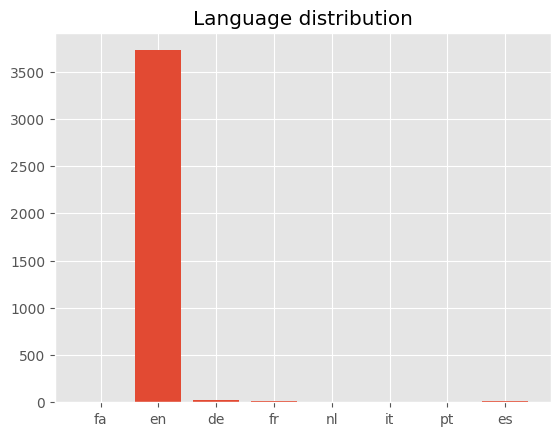

In [ ]:
df['language'] = languages
plt.bar(range(len(dict_languages)), list(dict_languages.values()), align='center')
plt.xticks(range(len(dict_languages)), list(dict_languages.keys()))
plt.title("Language distribution")
plt.show()

In [ ]:
df = df[df['language'] == 'en']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3725 entries, 3936 to 1884
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        3725 non-null   int64 
 1   paper_id          3725 non-null   object
 2   doi               3725 non-null   object
 3   abstract          3725 non-null   object
 4   body_text         3725 non-null   object
 5   authors           3725 non-null   object
 6   title             3725 non-null   object
 7   journal           3725 non-null   object
 8   abstract_summary  3725 non-null   object
 9   language          3725 non-null   object
dtypes: int64(1), object(9)
memory usage: 320.1+ KB


In [ ]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['its',
 'with',
 're',
 'somehow',
 'towards',
 'formerly',
 'either',
 'namely',
 'anyone',
 '‘s']

In [ ]:
add_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure',
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.',
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in add_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [ ]:
pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz

In [ ]:
import en_core_sci_sm

In [ ]:
parser = en_core_sci_sm.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def tokenizer(sentence):
    tokens = parser(sentence)
    tokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in tokens ]
    tokens = [ word for word in tokens if word not in stopwords and word not in punctuations ]
    tokens = " ".join([i for i in tokens])
    return tokens

In [ ]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(tokenizer)

In [2]:
df= pd.read_csv("data_processed.csv")

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_vectorize(text, maxx_features):

    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [4]:
text = df['processed_text'].values
no_of_features = 2**12

X = tfidf_vectorize(text, no_of_features)

In [5]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_pca= pca.fit_transform(X.toarray())
X_pca.shape

(3725, 1728)

In [6]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [7]:
# from sklearn import metrics
# from scipy.spatial.distance import cdist


# distortions = []
# K = range(2, 30)
# for k in K:
#     k_means = KMeans(n_clusters=k, random_state=42).fit(X_pca)
#     k_means.fit(X_pca)
#     distortions.append(sum(np.min(cdist(X_pca, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
#     print('Found distortion for {} clusters'.format(k))

In [8]:
# X_line = [K[0], K[-1]]
# Y_line = [distortions[0], distortions[-1]]

# plt.plot(K, distortions, 'b-')
# plt.plot(X_line, Y_line, 'r')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method')
# plt.show()

In [9]:
from sklearn.cluster import KMeans

In [10]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_pca)
df['y'] = y_pred

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50)
X_tsne = tsne.fit_transform(X.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3725 samples in 0.015s...
[t-SNE] Computed neighbors for 3725 samples in 4.236s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3725
[t-SNE] Computed conditional probabilities for sample 2000 / 3725
[t-SNE] Computed conditional probabilities for sample 3000 / 3725
[t-SNE] Computed conditional probabilities for sample 3725 / 3725
[t-SNE] Mean sigma: 0.385634
[t-SNE] KL divergence after 250 iterations with early exaggeration: 106.225403
[t-SNE] KL divergence after 1000 iterations: 2.499538


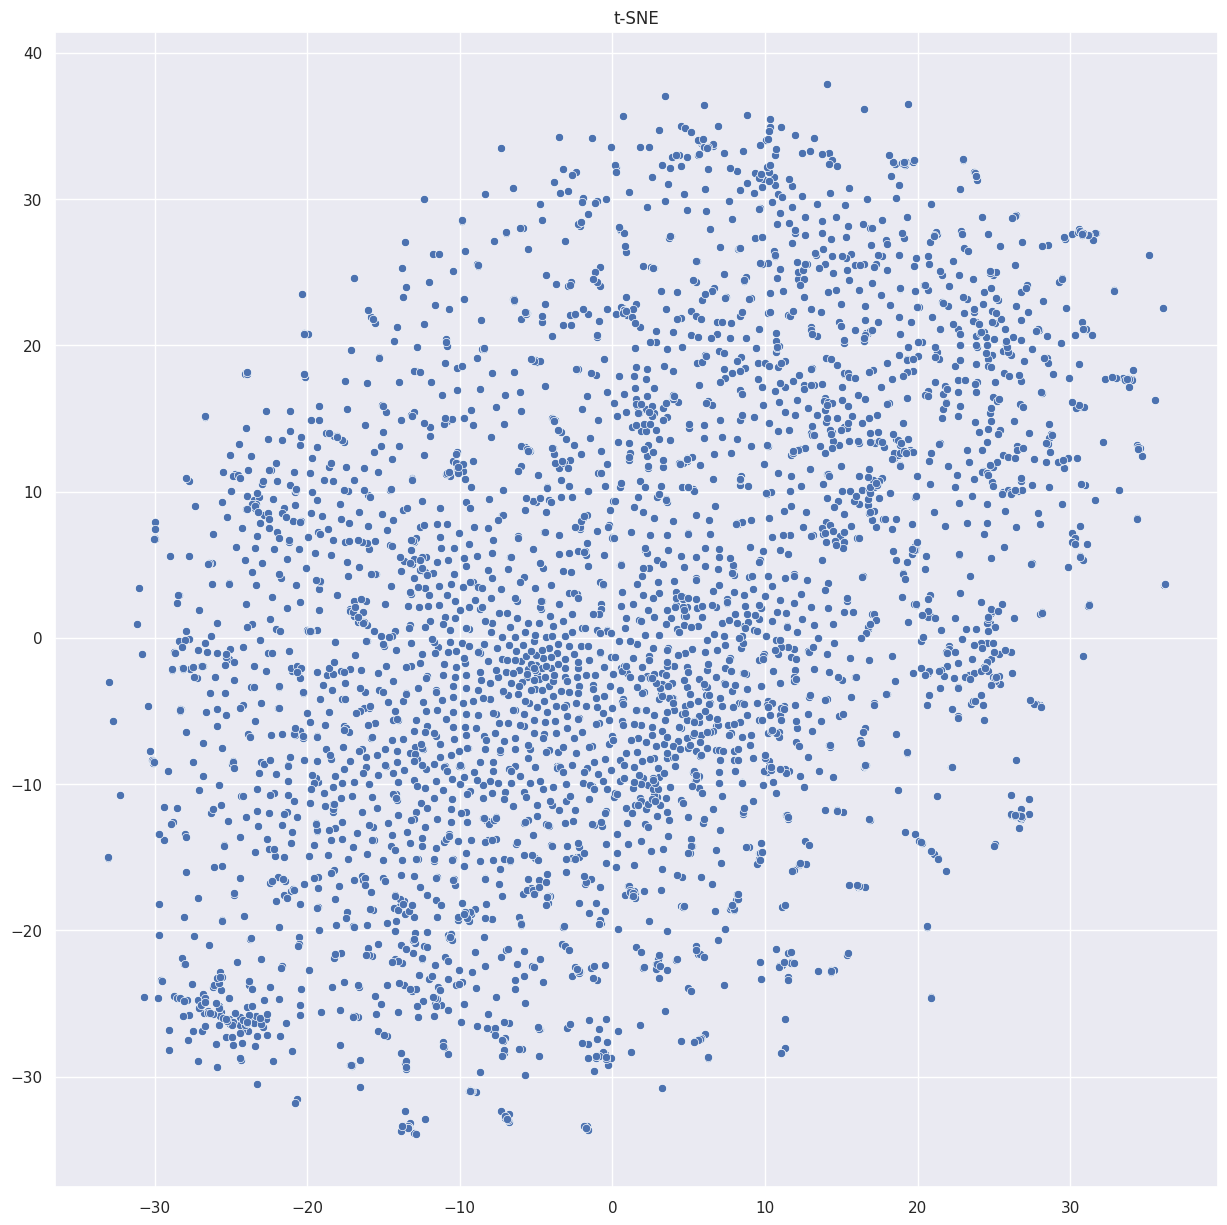

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(15,15)})

palette = sns.color_palette("bright", 1)

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], palette=palette)
plt.title('t-SNE')
plt.savefig("tsne.png")
plt.show()

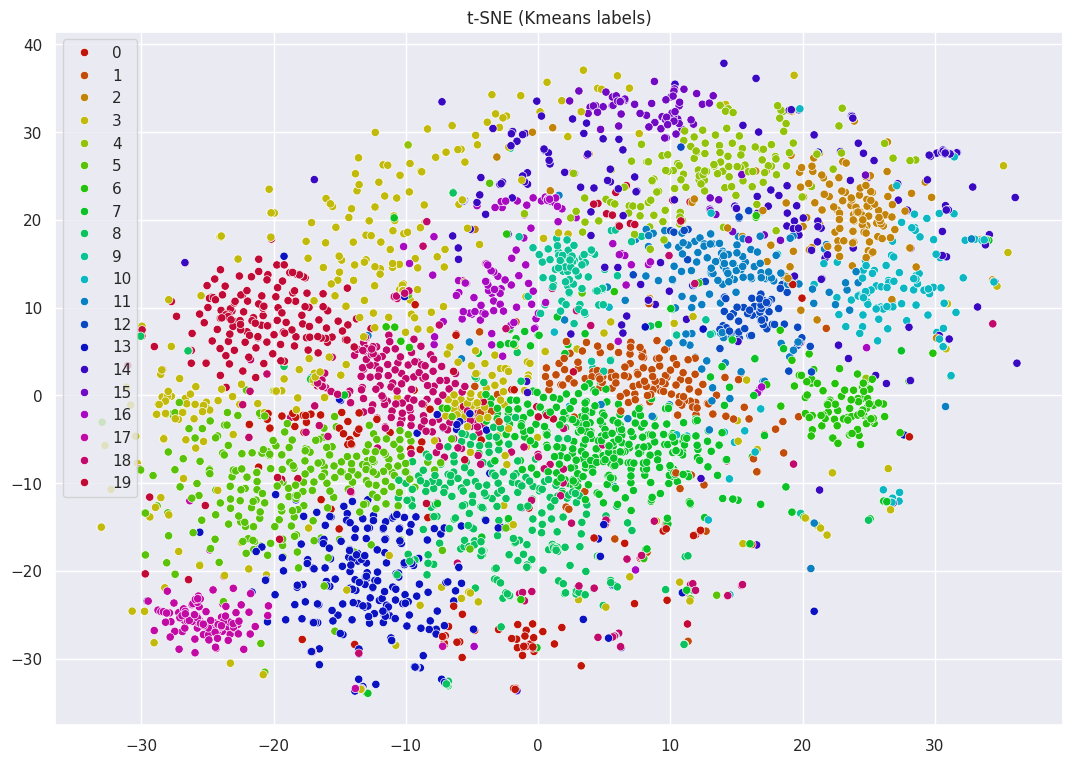

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(13,9)})

palette = sns.hls_palette(20, l=.4, s=.9)

sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE (Kmeans labels)')
plt.savefig("tsne_kmeans.png")
plt.show()

In [14]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
vectorizers_array = []

for i in range(0, 20):
    vectorizers_array.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [16]:
vectorizers_array[0]

CountVectorizer(max_df=0.9, min_df=5, stop_words='english',
                token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}')

In [17]:
vectorized_data = []

for cluster, vec in enumerate(vectorizers_array):
    try:
        vectorized_data.append(vec.fit_transform(df.loc[df['y'] == cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances" + str(cluster))
        vectorized_data.append(None)

In [18]:
len(vectorized_data)

20

In [19]:
Topics_per_cluster = 20


lda_models = []

for i in range(0, 20):
    lda = LatentDirichletAllocation(n_components=Topics_per_cluster, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)

lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)

In [20]:
transformed_lda_data = []

for cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(cluster))

    if vectorized_data[cluster] != None:
        transformed_lda_data.append((lda.fit_transform(vectorized_data[cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19


In [23]:
def topics_(model, vectorizer, top_n=3):
    words = []
    keywords = []

    for index, topic in enumerate(model.components_):
        words_2 = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for w in words_2:
            if w[0] not in words:
                keywords.append(w)
                words.append(w[0])

    keywords.sort(key = lambda x: x[1])
    keywords.reverse()
    return_values = []
    for i in keywords:
        return_values.append(i[0])
    return return_values

In [33]:
all_keywords = []
for vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(vectorizer))

    if vectorized_data[vectorizer] != None:
        all_keywords.append(topics_(lda, vectorizers_array[vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19


In [34]:
all_keywords[0][:10]

['food',
 'women',
 'risk',
 'children',
 'mothers',
 'countries',
 'participants',
 'people',
 'school',
 'pregnant']

In [35]:
len(all_keywords)

20

In [36]:
f=open('topics.txt','w')

count = 0

for i in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(i) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(i) + "\n")
    count += 1

f.close()

In [37]:
import pickle

pickle.dump(df, open("df_data.p", "wb" ))

pickle.dump(X_tsne, open("X_tsne.p", "wb" ))

pickle.dump(y_pred, open("y_pred.p", "wb" ))

In [38]:

! mkdir lib
! ls
! wget https://raw.githubusercontent.com/rodeketan/TM_COVID/main/call_backs.py
! mv call_backs.py lib/.
! ls lib/

mkdir: cannot create directory ‘lib’: File exists
data_processed.csv  lib			     sample_data  tsne_kmeans.png  X_tsne.p
df_data.p	    research_navigator.html  topics.txt   tsne.png	   y_pred.p
--2024-04-05 17:09:46--  https://raw.githubusercontent.com/rodeketan/TM_COVID/main/call_backs.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3199 (3.1K) [text/plain]
Saving to: ‘call_backs.py’

call_backs.py       100%[===================>]   3.12K  --.-KB/s    in 0s      

2024-04-05 17:09:46 (35.2 MB/s) - ‘call_backs.py’ saved [3199/3199]

call_backs.py  __pycache__


In [39]:
import os

topic_path = os.path.join(os.getcwd(), 'topics.txt')
with open(topic_path) as f:
    topics = f.readlines()

In [40]:
from lib.call_backs import input_callback, selected_code

In [41]:
import pandas as pd
from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CustomJS, Slider, TextInput, Div, Paragraph, TapTool
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
from bokeh.layouts import column, row, layout
from bokeh.palettes import Category20
from bokeh.io import curdoc


output_notebook()

y_labels = y_pred

source = ColumnDataSource(data=dict(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    x_backup=X_tsne[:, 0],
    y_backup=X_tsne[:, 1],
    desc=y_labels,
    titles=df['title'],
    authors=df['authors'],
    journal=df['journal'],
    abstract=df['abstract_summary'],
    labels=["C-" + str(x) for x in y_labels],
    links=df['doi']
))

hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
    ("Link", "@links")
], point_policy="follow_mouse")

mapper = linear_cmap(field_name='desc',
                     palette=Category20[20],
                     low=min(y_labels), high=max(y_labels))
curdoc().theme = 'dark_minimal'

plot = figure(width=1200, height=850,
              tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'],
              title="Clustering of the COVID-19 Literature",
              toolbar_location="above")


scatter = plot.scatter('x', 'y', size=5,
                       source=source,
                       fill_color=mapper,
                       line_alpha=0.3,
                       line_color="black",
                       legend_field='labels')
plot.legend.title = 'Cluster'


text_banner = Paragraph(text='Slider shows the keywords corresponding to the cluster number', height=90)
input_callback_1 = input_callback(plot, source, text_banner, topics)


div_curr = Paragraph(text="""Link can be viewed by clicking""", height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected


slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #")
keyword = TextInput(title="Search:", value="")


slider.js_on_change("value", input_callback_1)
keyword.js_on_change("value", input_callback_1)



input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider


div_curr.styles = {'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.styles = {'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}

l = layout([

    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot]
])
l.sizing_mode = "scale_both"


output_file('research_navigator.html')
show(l)
